# Delete-1 Jackknife Explained

# Load packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats

# Load dataset

In [2]:
from sklearn.datasets import load_boston
tmp = load_boston()
y = tmp.target
X = tmp.data[:,[5,12]]

# Data Splitting
Let's reserve 50% for testing lateron

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

N = len(y_train)

# Model Specification
We will use a linear regression model but it could be any model with a fixed set of parameters/weights to be estimated.

In [4]:
def estimator_fn(y, X, bias=True):
    if bias:
        X_ = np.c_[np.ones(shape=(len(y), 1)), X]
    else:
        X_ = X
    # OLS by LU decomposition
    return np.linalg.solve(np.dot(X_.T, X_), np.dot(X_.T, y))

In [5]:
def predictor_fn(X, weights, bias=True):
    if bias:
        X_ = np.c_[np.ones(shape=(len(X), 1)), X]
    else:
        X_ = X
    return np.dot(X_, weights)

In [6]:
def loss_fn(y, y_pred):
    return np.mean((y - y_pred)**2)

# Model Estimation

## Loop over the Subsamples
In Delete-1 Jackknife `N` subsamples are created that leaves out 1 of the `N` observations. 
Then the parameters/weights of the base model are estimated for each of the `N` subsamples.

In [7]:
%%time
params = []  # store estimated weights lateron

# row indicies for each observation
idx = np.arange(0, N)

#loop over subsamples
for i in idx:
    # create true/false mask for the i-th subsample
    # there is one observation masked false!
    mask = idx != i

    #estimate the the model parameters for the i-th subsample
    beta = estimator_fn(y_train[mask], X_train[mask, :])
    params.append(beta)  # store it

params = np.vstack(params)  # convert to numpy array

CPU times: user 42.3 ms, sys: 2.76 ms, total: 45.1 ms
Wall time: 89.1 ms


## Eyeball the subsamples' estimated parameters/weights ('Jackknife replicates')

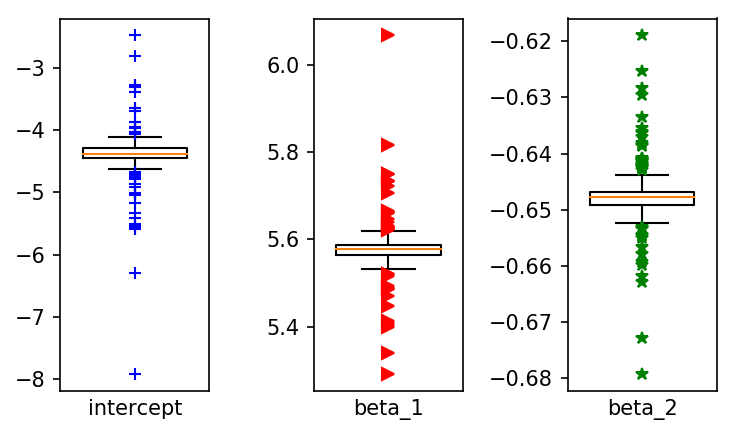

In [8]:
fig = plt.figure(figsize=(5,3), dpi=150)
names = ['intercept', 'beta_1', 'beta_2']
color = ['b+', 'r>', 'g*']
bwidth = .7

for i in range(3):
    ax = plt.subplot('13'+str(i+1))
    ax.boxplot(x=params[:,i], sym=color[i], widths=bwidth);
    ax.set_xlabel(names[i])
    ax.set_xticks([])

plt.tight_layout()

Remember, the classic Delete-1 Jackknife just leaves out 1 observation for each subsample. 
This is already enough to create subsamples with fluctating parameter estimates (The Jackknife Replicates). 
For example, the *intercept* parameter estimates are centered around `-4.5` but one subsample resulted in an almost `-8.0` parameter value, or almost twice as negative. 
The Jackknife method literally *average out* the outliers. 

# Aggregate Estimates
In a first step, the subsamples parameters/weights are aggregated:

- $\theta_{biased}$ : Biased Jackknife Estimate (mean of weights)
- $SE(\theta)$ : Jackknife Standard Error (standard deviation of weights)
- $SE(\theta) / |\theta_{biased}|$ : Quick-n-Dirty indicator for parameter/weight stability

And finally, the mathematically correct answer

- $\theta_{jack}$ : Bias-corrected Jackknife Estimate (use this as model parameters/weights!)
- Jackknife t-Statistics (reject the whole model if any parameter/weight is unstable)

## Biased Jackknife Estimate
The biased **Jackknife Estimate** is the mean of a specific parameter estimate (e.g. the intercept) for all subsamples.

$$
\theta_{biased} = \frac{1}{n} \sum_{i=1}^n \theta_{(i)}
$$

In our example, the biased Jackknife Estimate is 

In [9]:
theta_biased = np.mean(params, axis=0)
theta_biased

array([-4.39632188,  5.57867761, -0.64774153])

## Jackknife Standard Error 
The core of the Jackknife procedure is the question how stable model parameters actually are. 
The **Standard Error (SE) of the Jackknife Estimates** is

$$
SE(\theta) = \sqrt{ \frac{n - 1}{n} \sum_{i=1}^n \left(\theta_{(i)} - \theta_{biased}\right)^2 }
$$

In [10]:
se_jack = np.sqrt( (N-1)/N * np.sum((params - theta_biased)**2, axis=0) )
se_jack

array([6.58036053, 0.94682775, 0.08295471])

## Quick-n-Dirty indicator for parameter/weight stability
What parameters are the most unstable?
It is not really scientific but we can already guess potentially unstable parameter estimates without bias-correction by

$$
\frac{SE(\theta)}{|\theta_{biased}|}
$$

A low standard error per absolute parameter value is desirable (lower is better or more stable). 
In our example, the intercept seems problematic.

In [11]:
se_jack / abs(theta_biased)

array([1.4967877 , 0.16972261, 0.12806761])

## Bias-corrected Jackknife Estimate
The **unbiased** or **bias-corrected Jackknife Estimate** is the parameter estimate of the full sample minus a Jackknife specific bias-correction

$$
\theta_{jack} = \theta_{all} - bias_{jack}
$$

First, let estimate the model on the full sample

In [12]:
theta_all = estimator_fn(y_train, X_train)
theta_all

array([-4.39554312,  5.57856979, -0.64774242])

The **Jackknife Bias-Correction** $bias_{jack}$ is

$$
bias_{jack} = (n - 1) (\theta_{all} - \theta_{biased})
$$

In [13]:
bias_jack = (N - 1) * (theta_biased - theta_all)
bias_jack

array([-0.19624726,  0.02717091,  0.00022508])

thus

In [14]:
theta_jack = theta_all - bias_jack
theta_jack

array([-4.19929586,  5.55139888, -0.64796751])

Substitution merge both formulas into

$$
\theta_{jack} = n \, \theta_{all} - (n - 1) \, \theta_{biased}
$$

In our example,

In [15]:
theta_jack = N * theta_all - (N - 1) * theta_biased
theta_jack

array([-4.19929586,  5.55139888, -0.64796751])

## Jackknife t-Statistics - What parameters are unstable?

The t-Statistics is simply

In [16]:
tscore = theta_jack / se_jack
tscore

array([-0.6381559 ,  5.86315609, -7.81109965])

The two-sided p-value is

In [17]:
M = len(tscore);
pval = scipy.stats.t.sf(np.abs(tscore), N-M-1)*2
pval.round(4)

array([0.524, 0.   , 0.   ])

And as we already guessed, the intercept parameter estimates are just random (`0.524` is way of off being close to Zero), i.e. the intercept parameter estimates in the Jackknife subsamples just happenend by *chance*.

**As a consequence the whole model is rejected.**
The analysis is done. 

# Prediction 
However, we could still burn through our test set. 
It does not matter anyways ;)


In [18]:
# theta_all estimated from full training set
y_pred  = predictor_fn(X_train, theta_all)
mse_all_in = loss_fn(y_train, y_pred)

y_pred  = predictor_fn(X_test, theta_all)
mse_all_out = loss_fn(y_test, y_pred)

mse_all_in, mse_all_out

(29.011239937925932, 32.287748888398255)

In [19]:
# theta_jack, the biased corrected jackknife weights
y_pred  = predictor_fn(X_train, theta_jack)
mse_jack_in = loss_fn(y_train, y_pred)

y_pred  = predictor_fn(X_test, theta_jack)
mse_jack_out = loss_fn(y_test, y_pred)

mse_jack_in, mse_jack_out

(29.01203730017213, 32.25662876562247)

The predictive performance of classic Linear Regression and Jackknife Estimates are not really different. 
And again, it highlights that **Delete-1 Jackknife is useful for finding unstable parameters** (see Jackknife t-Test) and rejecting a specified model for being potentially erratic, overfitted, prone to outliers, etc. during model development or model selection.

# Links
* Bradley Efron, R.J. Tibshirani (1993), "An Introduction to the Bootstrap", Chapter 11, [Google Books](https://books.google.de/books?id=gLlpIUxRntoC&lpg=PR14&ots=A9xuU4O5H5&lr&pg=PA141#v=onepage&q&f=false)